<a href="https://colab.research.google.com/github/shaival99/News-Summarization-using-Abstractive-Techniques/blob/main/Bidirectional%20LSTM%20with%20Attention/Bidirectional_LSTM_RNN_with_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glove6b/glove.6B.200d.txt
/kaggle/input/glove6b/glove.6B.50d.txt
/kaggle/input/glove6b/glove.6B.300d.txt
/kaggle/input/glove6b/glove.6B.100d.txt
/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/validation.csv
/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/train.csv
/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/test.csv
/kaggle/input/news-summary/news_summary_more.csv
/kaggle/input/news-summary/news_summary.csv


In [ ]:
# Loading Essential libraries 
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'
%config Completer.use_jedi = False # this to force autocompletion 
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
df1 = pd.read_csv('../input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/train.csv', encoding= 'latin-1')
df1 = df1.sample(frac=0.2)

In [ ]:
df1 = df1.drop(columns=['id'])

In [ ]:
df1.tail()

,article,highlights
220940,As I circled the huge roundabout at the foot o...,Helen passed her driving test 22 years ago .\n...
42558,When foreign dignitaries spend private time wi...,Photo of visit from New Zealand Prime Minister...
140402,"LOS ANGELES, California (CNN) -- Mason Jenning...","Mason Jennings' new CD, ""Blood of Man,"" is ver..."
194928,"By . Lucy Crossley . PUBLISHED: . 05:05 EST, 1...","Timmy Wallace, 24, was beaten and tortured by ..."
285401,"By . Lucy Waterlow . PUBLISHED: . 12:44 EST, 8...",Proud mother joined her champion son at No 10 ...


### Lets do some text preprocessing 

In [ ]:
df1['highlights'] = df1.highlights.apply(lambda x: x.lower())
df1['article'] = df1.article.apply(lambda x: x.lower())

In [ ]:
!pip install text_hammer
import  text_hammer as th

     |████████████████████████████████| 115 kB 617 kB/s 


In [ ]:
df1.shape

(57423, 2)

In [ ]:
# Remove quotes 
def Text_cleaning(df, column):
    column = column
    print(column)
    import re
    """column must be a string value"""
    df[column] = df[column].progress_apply(lambda x: re.sub('"',"'", x))
    df[column] = df[column].progress_apply(lambda x:th.remove_special_chars(x))
    df[column] = df[column].progress_apply(lambda x:th.remove_html_tags(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_urls(x))
    df[column] = df[column].progress_apply(lambda x:th.cont_exp(x))
    df[column] = df[column].progress_apply(lambda x: re.sub('[^a-zA-Z]+',' ', x))
    df[column] = df[column].progress_apply(lambda x:' '.join([x for x in x.split() if len(x)>=2]) )
    return df[column]



In [ ]:
cleaned_highlights = Text_cleaning(df1, 'highlights')

highlights


  0%|          | 0/57423 [00:00<?, ?it/s]

  0%|          | 0/57423 [00:00<?, ?it/s]

  0%|          | 0/57423 [00:00<?, ?it/s]

  0%|          | 0/57423 [00:00<?, ?it/s]

  0%|          | 0/57423 [00:00<?, ?it/s]

  0%|          | 0/57423 [00:00<?, ?it/s]

  0%|          | 0/57423 [00:00<?, ?it/s]

In [ ]:
cleaned_article = Text_cleaning(df1, 'article')

article


  0%|          | 0/57423 [00:00<?, ?it/s]

  0%|          | 0/57423 [00:00<?, ?it/s]

  0%|          | 0/57423 [00:00<?, ?it/s]

  0%|          | 0/57423 [00:00<?, ?it/s]

  0%|          | 0/57423 [00:00<?, ?it/s]

  0%|          | 0/57423 [00:00<?, ?it/s]

  0%|          | 0/57423 [00:00<?, ?it/s]

In [ ]:
cleaned_df1 = pd.DataFrame({'highlights': cleaned_highlights, 'article': cleaned_article})
cleaned_df1.head()

,highlights,article
33917,hotel guests who go green are happier with the...,dan condon believes in recycling just not when...
92272,hunger games fans can find many of the locatio...,cnnwhen people think of city that stands in fo...
264812,brendan rodgers says england rush to put press...,liverpool forward raheem sterling needs protec...
222181,purgatorius was small mammal that lived on die...,earths earliest primates have taken step up in...
183625,plant operators will begin the delicate work o...,cnn more than two years after an earthquake an...


In [ ]:
cleaned_df1.to_csv('newdf1_cleaned.csv', index = False)

In [ ]:
cleaned_df1 = pd.read_csv('./newdf1_cleaned.csv')

### Some analysis to decide the max_len_headlines and max_len_text

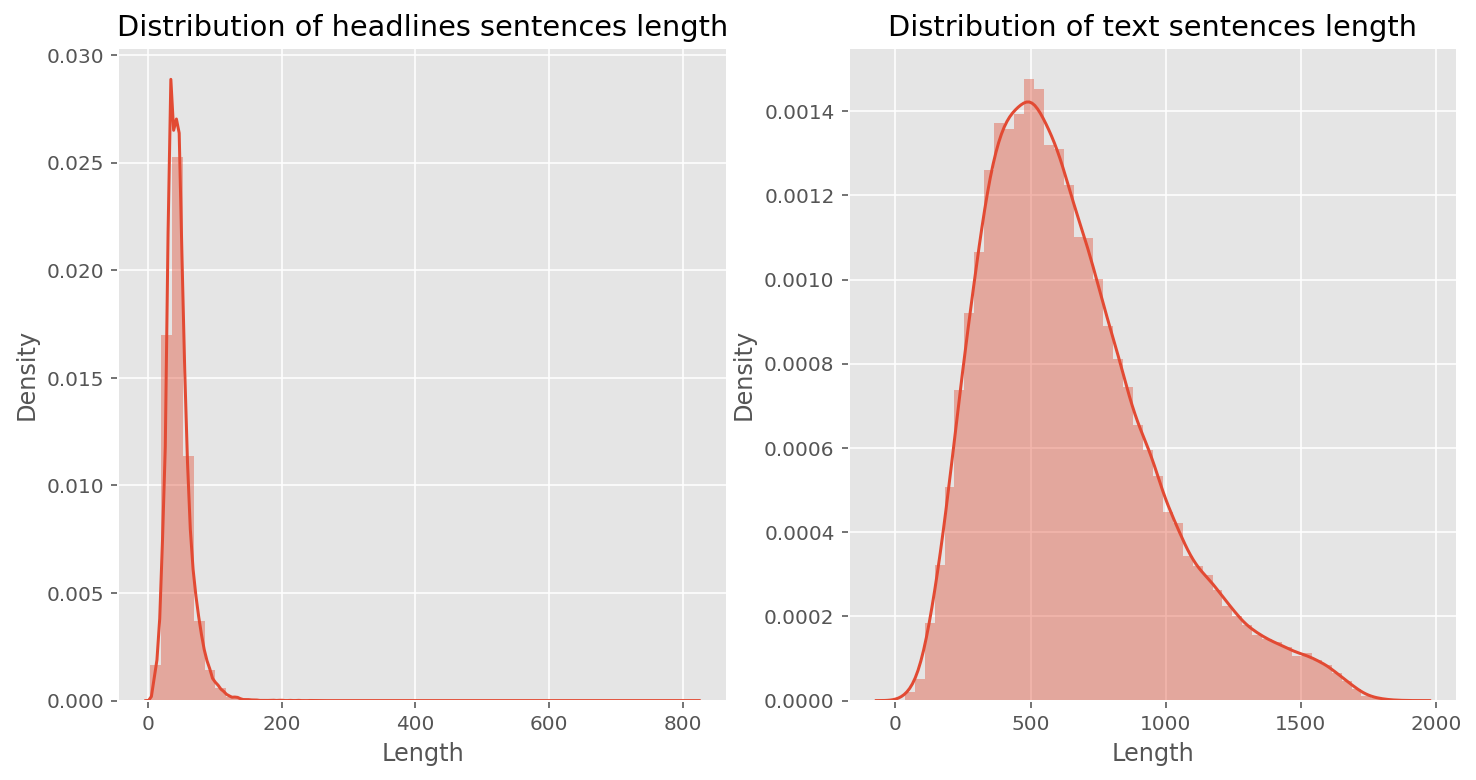

In [ ]:
plt.figure(figsize=(12,6))
plt.style.use('ggplot')
plt.subplot(1, 2, 1)
sns.distplot(df1['highlights'].str.split().apply(len))
plt.title('Distribution of headlines sentences length')
plt.xlabel('Length')

plt.style.use('ggplot')
plt.subplot(1, 2, 2)
sns.distplot(df1['article'].str.split().apply(len))
plt.title('Distribution of text sentences length')
plt.xlabel('Length')
plt.show()

In [ ]:
cleaned_df1['highlights'] = cleaned_df1.highlights.apply(lambda x: 'sostok ' +str(x) + ' eostok')

In [ ]:
cleaned_df1.head()

,highlights,article
0,sostok hotel guests who go green are happier w...,dan condon believes in recycling just not when...
1,sostok hunger games fans can find many of the ...,cnnwhen people think of city that stands in fo...
2,sostok brendan rodgers says england rush to pu...,liverpool forward raheem sterling needs protec...
3,sostok purgatorius was small mammal that lived...,earths earliest primates have taken step up in...
4,sostok plant operators will begin the delicate...,cnn more than two years after an earthquake an...


In [ ]:
cleaned_df1['len_highlights'] = cleaned_df1.highlights.apply(lambda x: len(x.split()))
cleaned_df1['len_article'] = cleaned_df1.article.apply(lambda x:len(x.split()))

In [ ]:
cleaned_df1.head()

,highlights,article,len_highlights,len_article
0,sostok hotel guests who go green are happier w...,dan condon believes in recycling just not when...,53,1601
1,sostok hunger games fans can find many of the ...,cnnwhen people think of city that stands in fo...,33,309
2,sostok brendan rodgers says england rush to pu...,liverpool forward raheem sterling needs protec...,57,842
3,sostok purgatorius was small mammal that lived...,earths earliest primates have taken step up in...,22,732
4,sostok plant operators will begin the delicate...,cnn more than two years after an earthquake an...,52,317


#### here for deciding the length of the text we need to understand the distribution of the graph

In [ ]:
for i in range(80,100,5):
    var = cleaned_df1['len_highlights'].values
    var = np.sort(var, axis = None)
    print('{} percentile value is {}'.format(i, var[int(len(var)*(float(i)/100))]))
    print(("100 percentile value is ", var[-1]))

80 percentile value is 59
('100 percentile value is ', 820)
85 percentile value is 63
('100 percentile value is ', 820)
90 percentile value is 70
('100 percentile value is ', 820)
95 percentile value is 82
('100 percentile value is ', 820)


In [ ]:
for i in range(80,100,5):
    var = cleaned_df1['len_article'].values
    var = np.sort(var, axis = None)
    print('{} percentile value is {}'.format(i, var[int(len(var)*(float(i)/100))]))
    print(("100 percentile value is ", var[-1]))

80 percentile value is 889
('100 percentile value is ', 1871)
85 percentile value is 971
('100 percentile value is ', 1871)
90 percentile value is 1088
('100 percentile value is ', 1871)
95 percentile value is 1273
('100 percentile value is ', 1871)


In [ ]:
max_len_article = 1000

max_len_highlights = 90

#### This is most important step to filter out those sentences who follows condition

In [ ]:
cleaned_df1 = cleaned_df1[(cleaned_df1.len_article <= 1000)*(cleaned_df1.len_highlights <= 90)]

In [ ]:
cleaned_df1.head()

,highlights,article,len_highlights,len_article
1,sostok hunger games fans can find many of the ...,cnnwhen people think of city that stands in fo...,33,309
2,sostok brendan rodgers says england rush to pu...,liverpool forward raheem sterling needs protec...,57,842
3,sostok purgatorius was small mammal that lived...,earths earliest primates have taken step up in...,22,732
4,sostok plant operators will begin the delicate...,cnn more than two years after an earthquake an...,52,317
5,sostok dozens killed when militants raid sunni...,cnn at least people were killed early sunday w...,40,393


In [ ]:
cleaned_df1.shape

(48631, 4)

In [ ]:
cleaned_df1.len_article.max()

1000

#### Dividing our data for train test split

In [ ]:
from sklearn.model_selection import train_test_split
X_train1,X_test1,y_train1,y_test1 = train_test_split(
cleaned_df1.article, cleaned_df1.highlights, test_size = 0.2, random_state = 32, shuffle = True)

In [ ]:
print(X_train1.shape, y_test1.shape)

(38904,) (9727,)


### Time to prepare data 

In [ ]:
num_words_x= 35000
num_words_y = 25000
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

x_tokenizer1 = Tokenizer(filters='|', num_words = num_words_x)
y_tokenizer1 = Tokenizer(filters='|', num_words = num_words_y)

x_tokenizer1.fit_on_texts(cleaned_df1.article)
y_tokenizer1.fit_on_texts(cleaned_df1.highlights)

In [ ]:
x_voc1 = len(x_tokenizer1.word_index) + 1
y_voc1 = len(y_tokenizer1.word_index) + 1

In [ ]:
y_tr_seq1    =   y_tokenizer1.texts_to_sequences(y_train1) 
y_val_seq1   =   y_tokenizer1.texts_to_sequences(y_test1) 

#padding zero upto maximum length
y_tr1    =   pad_sequences(y_tr_seq1, maxlen=max_len_highlights, padding='post')
y_val1   =   pad_sequences(y_val_seq1, maxlen=max_len_highlights, padding='post')

#convert text sequences into integer sequences (i.e one-hot encodeing all the words)
x_tr_seq1    =   x_tokenizer1.texts_to_sequences(X_train1) 
x_val_seq1   =   x_tokenizer1.texts_to_sequences(X_test1)

#padding zero upto maximum length
x_tr1    =   pad_sequences(x_tr_seq1,  maxlen=max_len_article, padding='post')
x_val1   =   pad_sequences(x_val_seq1, maxlen=max_len_article, padding='post')

In [ ]:
print(x_tr1.shape, y_tr1.shape)

(38904, 1000) (38904, 90)


### We are going to use word embedding (glove vectors ) 

In [ ]:
## using 300 dimension word2vec model, since more dimension means more information
glove_vectors = {}
file = open('../input/glove6b/glove.6B.300d.txt', encoding = 'utf-8')
for line in file:
    values = line.split()
    word = values[0]
    vectors = np.asarray(values[1:])
    glove_vectors[word] = vectors
file.close()   

#### if word not available in our glove vector then that word will get 0 weightage

In [ ]:
glove_emb_matrix1 = np.zeros((num_words_x,300))
glove_emb_matrix1.shape

(35000, 300)

In [ ]:
%%time
for word, index in x_tokenizer1.word_index.items():
    if index < num_words_x: # since index starts with zero 
        embedding_vector = glove_vectors.get(word)
        if embedding_vector is not None:
            glove_emb_matrix1[index] = embedding_vector
    

CPU times: user 6.35 s, sys: 52.8 ms, total: 6.41 s
Wall time: 6.41 s


### Importing libraries for designing our architecture 

In [ ]:
from tensorflow.keras import models
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Bidirectional,Concatenate
from tensorflow.keras.layers import Dense, Flatten,Embedding
from tensorflow.keras import Input
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from keras.layers import Input,Dense, Activation, concatenate, Embedding, Flatten, Bidirectional, Concatenate
 
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from keras import optimizers


### This is attention layer and can be used in teacher forcing

In [ ]:
# now we will have to make attention classs
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>', U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)
            if verbose:
                print('Ws+Uh>', Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        
        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [ ]:
y_tr1.shape

(38904, 90)

### lets design our model architecture for training

In [ ]:
from keras import backend as K 
K.clear_session() 
latent_dim = 500 

# Encoder 
encoder_inputs1 = Input(shape=(max_len_article,)) 
enc_emb1 = Embedding(num_words_x, 300,input_length = x_tr1.shape[1],
                    trainable = False, weights = [glove_emb_matrix1])(encoder_inputs1) 

encoder_lstm_layer1 = Bidirectional(LSTM(latent_dim, return_state=True, return_sequences = True, 
                                             name = 'lstm_encoder1'), merge_mode = 'concat')

encoder_output1, forward_h1, forward_c1, backward_h1, backward_c1 = encoder_lstm_layer1(enc_emb1)

state_h1 = Concatenate()([forward_h1, backward_h1])
state_c1 = Concatenate()([forward_c1, backward_c1])
encoder_states1 = [state_h1, state_c1]

# Set up the decoder. 
decoder_inputs1 = Input(shape=(None,)) 
dec_emb_layer1 = Embedding(num_words_y,latent_dim, input_length=y_tr1.shape[1],trainable  = True) 
dec_emb1 = dec_emb_layer1(decoder_inputs1) 

#LSTM using encoder_states as initial state
decoder_lstm_layer1 = LSTM(2*latent_dim, return_state=True, return_sequences = True, name = 'lstm_decoder1')
decoder_output1 , decoder_h1, decoder_c1 = decoder_lstm_layer1(dec_emb1,
                                                   initial_state = encoder_states1)

attn_layer = AttentionLayer(name = 'attention_layer')

######### -------------Attention layer---------------------------
attn_out1, attn_states1 = attn_layer([encoder_output1, decoder_output1])
decoder_concat_input1 = Concatenate(axis=-1, name='concat')([decoder_output1, attn_out1])



#Dense layer
decoder_dense1 = TimeDistributed(Dense(num_words_y, activation='softmax')) 
decoder_outputs1 = decoder_dense1(decoder_concat_input1) 


model1 = Model([encoder_inputs1,decoder_inputs1], decoder_outputs1) 
model1.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')                                                          
# using sparse_categorical entropy will solve memory problem                                                          
model1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1000)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1000, 300)    10500000    input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 1000, 1000), 3204000     embedding[0][0]                  
______________________________________________________________________________________________

stacked decoder more often need more epochs for training so for now we will not use them


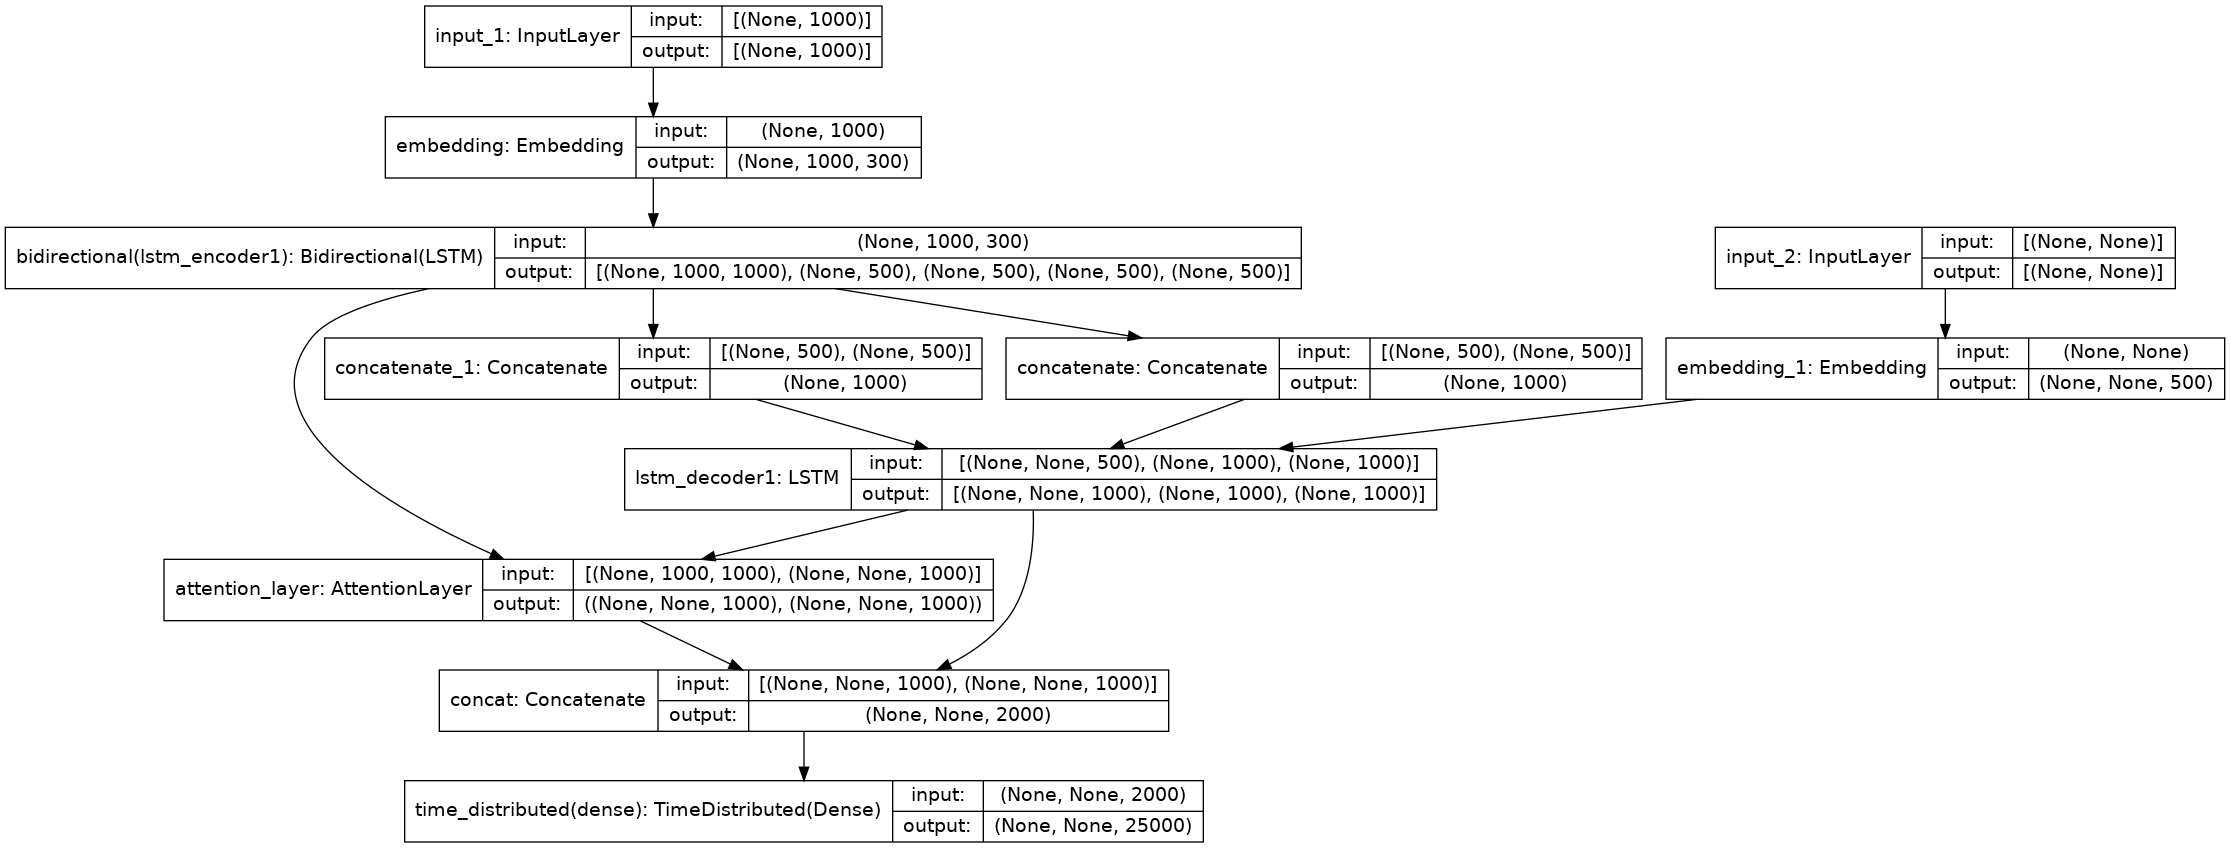

In [ ]:
plot_model(model1, to_file='model.png', show_shapes=True)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
batch_size=16

In [ ]:
checkpoint_filepath = './cp-{epoch:04d}.ckpt'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_freq=5*batch_size)

In [ ]:
## defining callbacks 
import keras
es = EarlyStopping(monitor='val_loss',patience = 10, mode='min', verbose=1)
lr = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', patience = 1, mode = 'min', verbose = 1)

In [ ]:
print(x_tr1.shape, y_tr1.shape)

(38904, 1000) (38904, 90)


In [ ]:
history=model1.fit([x_tr1,y_tr1[:,:-1]], y_tr1.reshape(y_tr1.shape[0],y_tr1.shape[1], 1)[:,1:] ,epochs=7,
                  callbacks=[es,lr,model_checkpoint_callback],
                  batch_size=16, validation_data=([x_val1,y_val1[:,:-1]], y_val1.reshape(y_val1.shape[0],y_val1.shape[1], 1)[:,1:]))

Epoch 1/7
2432/2432 [==============================] - 5293s 2s/step - loss: 3.4217 - val_loss: 2.9671
Epoch 2/7
2432/2432 [==============================] - 5275s 2s/step - loss: 2.8880 - val_loss: 2.8584
Epoch 3/7
2432/2432 [==============================] - 5308s 2s/step - loss: 2.7342 - val_loss: 2.7929
Epoch 4/7
2432/2432 [==============================] - 5286s 2s/step - loss: 2.5864 - val_loss: 2.7099
Epoch 5/7
2432/2432 [==============================] - 5310s 2s/step - loss: 2.4278 - val_loss: 2.6327
Epoch 6/7
2432/2432 [==============================] - 5275s 2s/step - loss: 2.2710 - val_loss: 2.5883
Epoch 7/7
2432/2432 [==============================] - 5279s 2s/step - loss: 2.1259 - val_loss: 2.5633


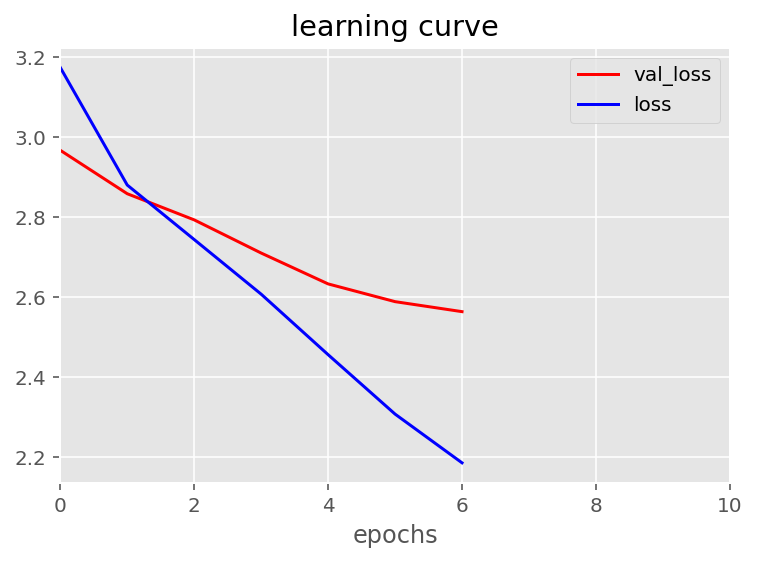

In [ ]:
plt.plot(history.history['val_loss'], color = 'r')
plt.plot(history.history['loss'], color = 'b')
plt.legend(['val_loss','loss'])
plt.xlim(0,10)
plt.xlabel('epochs')
plt.title('learning curve')
plt.show()

### Inference Model 

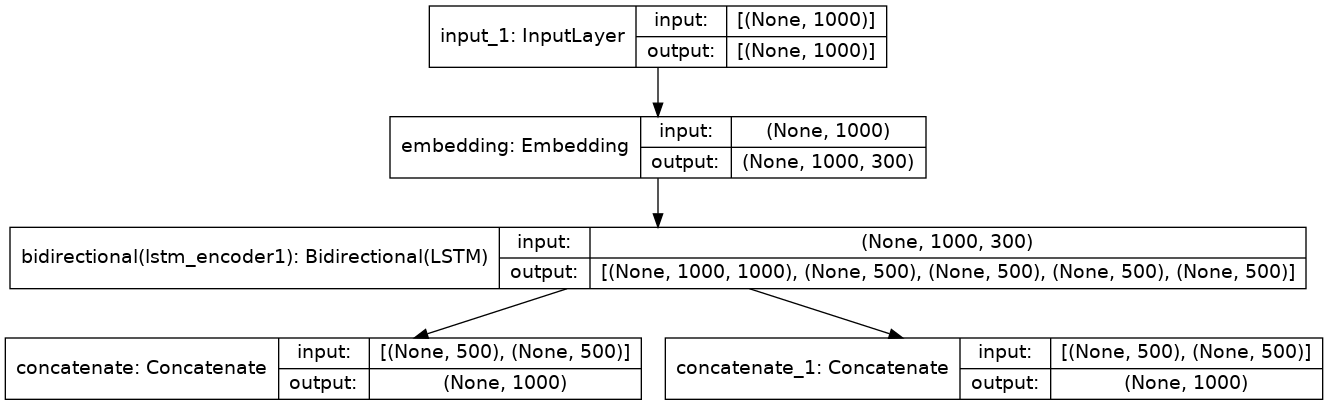

In [ ]:
encoder_model1 = Model(encoder_inputs1, [encoder_output1,state_h1, state_c1])
plot_model(encoder_model1,show_shapes=True)

In [ ]:

# now lets design our decoder model 
decoder_state_input_h1 = Input(shape=(2*latent_dim,))  # These states are required for feeding back to our next timestep decoder
decoder_state_input_c1 = Input(shape=(2*latent_dim,))
decoder_states_inputs1 = [decoder_state_input_h1, decoder_state_input_c1]
decoder_hidden_state_input1 = Input(shape=(max_len_article,2*latent_dim)) # since we are using bidirectional lstm


# Get the embeddings of the decoder sequence
dec_emb1= dec_emb_layer1(decoder_inputs1) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_output1, state_h21, state_c21 = decoder_lstm_layer1(dec_emb1, initial_state=decoder_states_inputs1)

attn_out_inf1, attn_states_inf1 = attn_layer([decoder_hidden_state_input1, decoder_output1])
decoder_inf_concat1 = Concatenate(axis=-1, name='concat')([decoder_output1, attn_out_inf1])


# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs1 = decoder_dense1(decoder_inf_concat1)

# Final decoder model
decoder_model1 = Model(
[decoder_inputs1] + [decoder_hidden_state_input1,decoder_state_input_h1, decoder_state_input_c1],
[decoder_outputs1] + [state_h21, state_c21])

In [ ]:
plot_model(decoder_model1,show_shapes = True)

In [ ]:
# defined a new variable to change words2index nd index2words
reverse_target_word_index1=y_tokenizer1.index_word
reverse_source_word_index1=x_tokenizer1.index_word
target_word_index1=y_tokenizer1.word_index

In [ ]:
# function for prediction of whole sentence by using loop
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out1,e_h1, e_c1 = encoder_model1.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq1 = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq1[0, 0] = target_word_index1['sostok']

    stop_condition = False
    decoded_sentence1 = ''
    while not stop_condition:
      
        output_tokens1, h1, c1 = decoder_model1.predict([target_seq1] + [e_out1,e_h1, e_c1])

        # Sample a token
        sampled_token_index1 = np.argmax(output_tokens1[0, -1, :])
        sampled_token1 = reverse_target_word_index1[sampled_token_index1]
        
        if(sampled_token1!='eostok'):
            decoded_sentence1 += ' '+sampled_token1

        # Exit condition: either hit max length or find stop word.
        if (sampled_token1 == 'eostok'  or len(decoded_sentence1.split()) >= (max_len_highlights-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq1 = np.zeros((1,1))
        target_seq1[0, 0] = sampled_token_index1

        # Update internal states
        e_h1, e_c1 = h1, c1

    return decoded_sentence1

In [ ]:
x_val1.shape

In [ ]:
## Testing phase 
decode_sequence(np.array(x_val1[0]).reshape(1,1000))

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index1['sostok']) and i!=target_word_index1['eostok']):
            newString=newString+reverse_target_word_index1[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index1[i]+' '
    return newString

In [ ]:
dict1 = {'article':[], 'original_summary':[], 'pred_summary':[]}

for i in range(50):
    dict1['article'].append(x_val1[i])
    dict1['original_summary'].append(seq2summary(y_val1[i]))
    dict1['pred_summary'].append(decode_sequence(x_val1[i].reshape(1,max_len_article)))

predicted_df1 = pd.DataFrame.from_dict(dict1)

In [ ]:
predicted_df1.to_csv('predicted_df1.csv', index = False)

In [ ]:
from IPython.display import FileLink
FileLink(r'predicted_df1.csv')

In [ ]:
for i in range(0,10):
#     print("Review:",seq2text(x_val1[i]))
    print("Original summary:",seq2summary(y_val1[i]))
    print("Predicted summary:",decode_sequence(x_val1[i].reshape(1,max_len_article)))
    print("\n")

In [ ]:
pip install rouge

In [ ]:
from rouge import Rouge

In [ ]:
rouge = Rouge()

for i in range(0,10):
    scores = rouge.get_scores(seq2summary(y_val1[i]), decode_sequence(x_val1[i].reshape(1,max_len_article)))
    print(scores)

In [ ]:
model = tf.keras.models.load_model('./cp-0007.ckpt/saved_model.pb')

In [ ]:
def load_pb(path_to_pb):
    with tf.gfile.GFile(path_to_pb, "rb") as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def, name='')
        return graph

In [ ]:
graph = load_pb('./cp-0007.ckpt/saved_model.pb')

In [ ]:
from tensorflow import gfile